# Using SmartAPI Registry metadata in summaries

## Setup

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## packages to work with objects
import requests
import pandas as pd
from textwrap import wrap  ## for plot labels

## to get around bugs
import nest_asyncio
nest_asyncio.apply()

In [2]:
## setup request
# headers = {"content-type": "application/json"}
registry_url = "https://smart-api.info/api/query/?fields=info,tags,_status&raw=1&size=1000"

## make request: check for success (200)
registry_request = requests.get(registry_url, headers={})
registry_request.status_code

200

In [7]:
## get response
registry = registry_request.json()

## parse response to get the information: uptime status, tags, x-translator, api name
registry_data = []
for ele in registry['hits']['hits']:
    tempDict = {'uptimeStatus': ele['_source']['_status']['uptime_status'],
                'refreshStatus': ele['_source']['_status']['refresh_status'],
                'name': ele['_source']['info']['title']}
    
    if ele['_source'].get('tags'):
        temp = [i.get('name') for i in ele['_source']['tags']]
        tempDict.update({"tags": temp})
    else:
        tempDict.update({"tags": []})
    
    if ele['_source']['info'].get('x-translator'):
        tempDict.update({            
            'team': ele['_source']['info']['x-translator'].get('team'),
            'component': ele['_source']['info']['x-translator'].get('component')
        })
    else:
        tempDict.update({            
            'team': [],
            'component': None
        })
    registry_data.append(tempDict)

## creating dataframe for easier exploring / printing
registry_df = pd.DataFrame.from_dict(registry_data)
registry_df = registry_df[['name', 'team', 'component', 'uptimeStatus', 'refreshStatus', 'tags']]

## changing the column to strings to make it easier to sort values
registry_df['team'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['team']]
registry_df['tags'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['tags']]

## replacing empty strings with None
registry_df['team'] = [None if not x else x for x in registry_df['team']]
registry_df['tags'] = [None if not x else x for x in registry_df['tags']]

## Registry API-level summary

### Comparing translator tag and x-translator use

In [8]:
## make flags whether api has a translator tag or x-translator field
registry_df['hasTranslatorTag'] =  [False if x is None else x 
                                    for x in registry_df.tags.str.contains('translator')]
registry_df['hasXTranslator'] =  [False if x is None else True for x in registry_df.team]

## print table
registry_df[['hasTranslatorTag', 'hasXTranslator']].value_counts().reset_index(name = "Num of APIs")

,hasTranslatorTag,hasXTranslator,Num of APIs
0,False,False,113
1,True,True,82
2,True,False,13
3,False,True,1


So there are 95 APIs with the "translator" tag, and 82 of them currently have the x-translator extension. There is one API with the x-translator extension and no "translator" tag. 

### Translator-tagged / x-translator APIs

In [9]:
## grab only the APIs with the translator tag 
translator_apis = registry_df[(registry_df['hasTranslatorTag']) | 
            (registry_df['hasXTranslator'])].copy()

## sort columns and rows to make format similar to Sarah's table
translator_apis = translator_apis[['team', 'component', 'name', 'uptimeStatus', 'refreshStatus', 'tags']]
translator_apis.sort_values(by=['team', 'component', 'name'], 
                            ignore_index = True, na_position = 'last', inplace = True)

Translator-tagged APIs with x-translator information. Another review may need to be done to address duplicate API registrations / different API registrations for BTE. 

In [10]:
summarytable1 = translator_apis[~ translator_apis['team'].isna()].copy()
summarytable1

,team,component,name,uptimeStatus,refreshStatus,tags
0,Clinical Data Provider,KP,Columbia Open Health Data (COHD),good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
1,Clinical Data Provider,KP,Columbia Open Health Data (COHD) for COVID-19 ...,good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
2,Clinical Data Provider,KP,OpenPredict API 🔮🐍,good,200,"translator,reasoner"
3,Clinical Data Provider,KP,Translator Knowledge Collaboratory API,good,200,"predicates,query,translator,reasoner"
4,Connections Hypothesis Provider,KP,Connections Hypothesis Provider API,unknown,200,"bayesian,translator,1.0.0"
...,...,...,...,...,...,...
78,Standards Reference Implementation Team,Utility,Name Resolver,unknown,200,translator
79,Standards Reference Implementation Team,Utility,Node Normalization,good,499,Interfaces
80,"Text Mining Provider,Service Provider",KP,Text Mining CO-OCCURRENCE API,good,200,"gene,chemical,association,annotation,query,tra..."
81,"Text Mining Provider,Service Provider",KP,Text Mining Targeted Association API,good,200,"gene,chemical,association,annotation,query,tra..."


The APIs WITHOUT x-translator information

In [11]:
## APIs without x-translator information
summarytable2 = translator_apis[translator_apis['team'].isna()].copy()
summarytable2.drop(columns = ['team', 'component'], inplace = True)
summarytable2

,name,uptimeStatus,refreshStatus,tags
83,Big GIM(Gene Interaction Miner),unknown,500,"translator,ISB,gene,similarity,tissue,TCGA,GIA..."
84,Broad probabilistic graphical models translator,unknown,499,translator
85,CMAQ Exposures API,incompatible,200,translator
86,ChEMBL API,good,499,"publication,translator"
87,Metadata Provider API,good,499,"metadata,biosample,translator"
88,NCATS ARA Scaffold,unknown,499,translator
89,NCATS KP Scaffold,unknown,499,translator
90,OpenAPI for indigo NCATS Biomedical Translator...,unknown,499,"query,translator,reasoner"
91,RGD API,good,499,"translator,gene"
92,ROBOKOP,good,499,"translator,reasoner"


#### APIs by team

<AxesSubplot:title={'center':'Num of APIs by team'}>

,name,Num of APIs
0,Service Provider,28
1,Ranking Agent,27
2,Standards Reference Implementation Team,6
3,"Multiomics Provider,Service Provider",5
4,Clinical Data Provider,4
5,Genetics Provider,2
6,Connections Hypothesis Provider,2
7,"Text Mining Provider,Service Provider",2
8,Molecular Data Provider,1
9,Exposures Provider,1


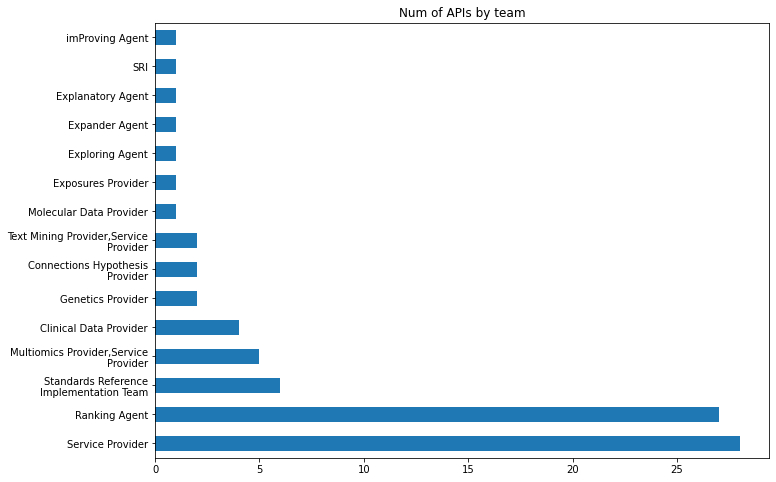

In [12]:
team_summary = translator_apis.team.value_counts().reset_index()
team_summary.columns = ['name', 'Num of APIs']
team_summary['plot_names'] = [ '\n'.join(wrap(i, 30)) for i in team_summary['name']]

team_summary.plot.barh(x='plot_names', y='Num of APIs', fontsize = 10, figsize=(11,8), rot=0, 
                       legend=False, title = "Num of APIs by team", xlabel="")
## table view
team_summary[['name', 'Num of APIs']]

#### APIs by component

,index,component
0,KP,70
1,ARA,8
2,Utility,5


<AxesSubplot:title={'center':'Num of APIs by component type'}>

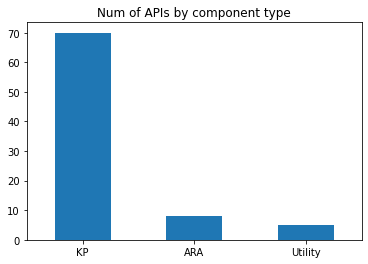

In [15]:
component_summary = translator_apis.component.value_counts().reset_index()
component_summary
component_summary.plot.bar(x='index', y='component', rot=0,
                       legend=False, title = "Num of APIs by component type", xlabel="")

#### APIs by uptime status

,index,uptimeStatus
0,good,73
1,unknown,20
2,incompatible,3


<AxesSubplot:title={'center':'Num of APIs by uptime status'}>

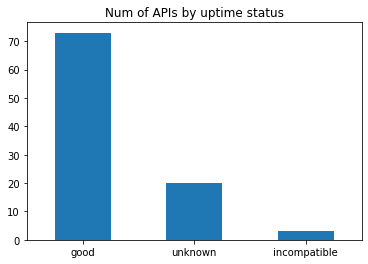

In [16]:
status_summary = translator_apis.uptimeStatus.value_counts().reset_index()
status_summary
status_summary.plot.bar(x='index', y='uptimeStatus', rot=0,
                       legend=False, title = "Num of APIs by uptime status", xlabel="")

#### APIs by refresh status

,index,refreshStatus
0,200,83
1,499,12
2,500,1


<AxesSubplot:title={'center':'Num of APIs by refresh status'}>

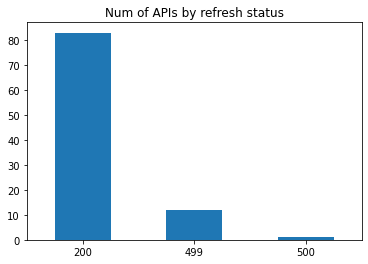

In [17]:
refresh_status_summary = translator_apis.refreshStatus.value_counts().reset_index()
refresh_status_summary
refresh_status_summary.plot.bar(x='index', y='refreshStatus', rot=0,
                       legend=False, title = "Num of APIs by refresh status", xlabel="")

## using x-translator and metaKG together

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

### Setup 

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

In [18]:
headers = {"content-type": "application/json"}

metaKG_url = "https://smart-api.info/api/metakg"

metaKG_request = requests.get(metaKG_url, headers=headers)
metaKG_request.status_code
## if the output is successful, code 200

200

In [19]:
metaKG = metaKG_request.json()

metaKG_operations = []
for edge in metaKG['associations']:
    tempdict = {
        "subject": edge['subject'],
        "object": edge['object'],
        "predicate": edge['predicate'],
        "provided_by": edge.get('provided_by'),
        "api_name": edge['api']['name']
    }
    if edge['api'].get('x-translator'):
        tempteam = edge['api']['x-translator'].get('team')
        if isinstance(tempteam, list):
            tempteam = ",".join(tempteam)
            if not tempteam:
                tempteam = None  
        tempdict.update({
            "api_team": tempteam,
            "api_component": edge['api']['x-translator'].get('component'),
        })
    else:
        tempdict.update({
            "api_team": None,
            "api_component": None,
        })
    metaKG_operations.append(tempdict)
    
operations_summary = pd.DataFrame.from_dict(metaKG_operations)

### MetaKG stats

MetaKG describes >1000 operations from 33 translator-tagged APIs

In [20]:
operations_summary.shape
operations_summary.api_name.nunique()

(1283, 7)

33

### predicates by team

In [21]:
operations1 = operations_summary[['predicate', 'api_name', 'api_team']].drop_duplicates()
operations1.api_team.value_counts().reset_index(name = 'Num of unique predicates')

,index,Num of unique predicates
0,Service Provider,160
1,"Multiomics Provider,Service Provider",7
2,"Text Mining Provider,Service Provider",5
3,Standards Reference Implementation Team,3
4,Clinical Data Provider,2
